# Curiosity-driven exploration with causality prior on the model in VectorIncrement environment

Setting the right GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

Imports

In [20]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

tf.compat.v1.enable_v2_behavior()

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

from vectorincrement import *
from common import *
from curiosity import *
from sparse_model_from_model import LinearStateTransitionModel, SparseModelLearner

from IPython.display import clear_output

Environment hyperparameters

In [4]:
v_n = 10
v_k = 10
v_seed = 43
do_transform = True
time_limit = 20

Agent hyperparameters

In [5]:
num_iterations = 500 # @param {type:"integer"}
collect_episodes_per_iteration = 5 # @param {type:"integer"}
replay_buffer_capacity = 1000 # @param {type:"integer"}

fc_layer_params = ()

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

# p norm
p_ord = 0.8

# regularization for reconstruction
eps_dinv = 1.

# for training observation model
model_W_train_epochs = 100

# for training feature model
model_sml_train_epochs = 100

Decoder: a linear transformation from observations to features

In [6]:
# two layers, will sync parameters between them

W = LinearStateTransitionModel(o=v_k, a=v_n)
sml = SparseModelLearner(o=v_k, a=v_n, f=v_n, p_ord=p_ord, eps_dinv=eps_dinv)

decoder_layer_agent = tf.keras.layers.Dense(v_n, input_shape=(v_k,), activation=None,
                             use_bias=False, kernel_initializer='random_normal')

Model of the environment

In [7]:
def env_model(oa):
    """Models next observation given o and a."""
    oa = oa[0]
    o = oa[:v_k]
    a = oa[v_k:]
    D = sml.D.numpy()
    Mf, Ma = sml.get_MfMa(sml.D)
    Mf = Mf.numpy()
    Ma = Ma.numpy()
    result = np.linalg.inv(D) @ (Ma @ a + Mf @ D @  o)
    return np.array([result])

Curiosity parameters

In [8]:
alpha = 1.0

curiosity_interval = 10

Creating a curiosity-wrapped environment

In [9]:
def get_env(add_curiosity_reward=True):
    """Return a copy of the environment."""
    env = VectorIncrementEnvironmentTFAgents(v_n=v_n, v_k=v_k, v_seed=v_seed,
                                             do_transform=do_transform)
    env = wrappers.TimeLimit(env, time_limit)
    if add_curiosity_reward:
        env = CuriosityWrapper(env, env_model, alpha=alpha)
    env = tf_py_environment.TFPyEnvironment(env)
    return env

In [10]:
train_env = get_env(add_curiosity_reward=True)
eval_env = get_env(add_curiosity_reward=False)

In [11]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    activation_fn=tf.keras.activations.relu,
    preprocessing_layers=decoder_layer_agent
    # for features: add preprocessing_layers=[...]
)

In [12]:
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [13]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [26]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [27]:
curiosity_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=1000000) # should never overflow

In [28]:
decoder_layer_agent = actor_net.layers[0].layers[0] # taking the copied layer with actual weights

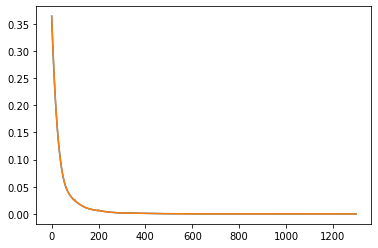

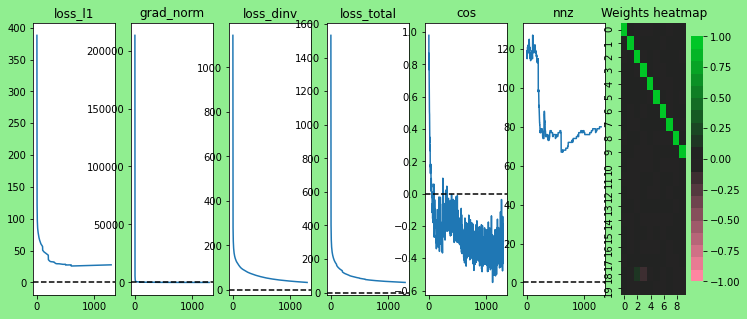

Model train step
Agent train step
Agent train step
Agent train step
Agent train step


In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
train_avg_return = compute_avg_return(eval_env, tf_agent.collect_policy, num_eval_episodes)
returns = [avg_return]
train_returns = [train_avg_return]

for _ in range(num_iterations):

  # Collect a few episodes using collect_policy and save to the replay buffer.
  collect_episode(train_env, tf_agent.collect_policy,
                  collect_episodes_per_iteration,
                  [replay_buffer,curiosity_replay_buffer])

  # Use data from the buffer and update the agent's network.
  experience = replay_buffer.gather_all()
  train_loss = tf_agent.train(experience)
  replay_buffer.clear()
    
  print("Agent train step")

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    train_avg_return = compute_avg_return(train_env, tf_agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1} Train curiosity Average return = {2}'.format(step, avg_return,
                                                                      train_avg_return))
    returns.append(avg_return)
    train_returns.append(train_avg_return)
    
  if step % curiosity_interval == 0:
    clear_output()
    xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)
    
    # fitting on observational data...
    W.fit(xs=xs, ys=ys, epochs=model_W_train_epochs)
    W.plot_loss()
    
    # setting weights from the agent to the model...
    sml.D.assign(decoder_layer_agent.get_weights()[0].T)
    
    # setting the new observation transition matrix
    sml.set_WoWa(*W.get_Wo_Wa())
    
    # fitting the SML model
    sml.fit(epochs=model_sml_train_epochs)
    
    # setting weights from the model to the agent...
    decoder_layer_agent.set_weights([sml.D.numpy().T])
    
    # plotting results for W and sml
    W.plot_loss()
    sml.process_results()
    
    curiosity_replay_buffer.clear()
    
    print("Model train step")

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
fig = plt.figure()
fig.patch.set_facecolor('lightgreen')
plt.title("Returns with added curiosity reward in training")
plt.plot(steps, returns, label="eval")
plt.plot(steps, train_returns, label="train")
plt.ylabel('Average Return')
plt.legend()
plt.xlabel('Step')

Evaluating the model

In [21]:
curiosity_replay_buffer.clear()
collect_episode(eval_env, tf_agent.collect_policy, 25, [curiosity_replay_buffer])
collect_episode(eval_env, tf_agent.policy, 25, [curiosity_replay_buffer])
xs, ys = buffer_to_dataset(curiosity_replay_buffer, v_n)
env_model.evaluate(xs, ys)

1000/1000 [==============================] - 0s 75us/sample - loss: 0.0344


0.034379313230514526

In [22]:
env_model.weights

[<tf.Variable 'dense_5/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 1.0450029e-04,  4.9015599e-01],
        [-2.4217597e-04,  1.7220677e+00]], dtype=float32)>,
 <tf.Variable 'dense_7/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[-1.8454093e-04, -2.3500546e-04],
        [ 1.3126345e-01,  5.0940210e-01],
        [-1.3580291e-04, -7.2934804e-03],
        [-8.6255110e-04,  7.0312656e-03]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(2,) dtype=float32, numpy=array([-0.07087477, -0.07355558], dtype=float32)>]

# The problem now

Features are very similar, it's not the case that they converge to $(1,0,1,0)$ and $(0,1,0,1)$

Solutions:
1. Grid search for hyperparams
2. Using a better graph sparsity loss (approximating number of edges)